In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sage.plot.plot3d.parametric_surface import ParametricSurface
import plotly.graph_objects as go
import plotly.express as px
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve

In [2]:
# Loading the CSV file
df = pd.read_csv('climate_api_data.csv')

df

,date,geocodigo,temp_min,temp_med,temp_max,precip_min,precip_med,precip_max,precip_tot,pressao_min,pressao_med,pressao_max,umid_min,umid_med,umid_max
0,2004-01-01,1302603,24.7052,26.7748,30.5519,0.0000,0.7406,3.0196,5.9251,0.9951,0.9980,1.0012,75.0331,87.1228,94.9243
1,2004-01-02,1302603,24.5850,26.8201,30.1501,0.0212,0.7749,3.4790,6.1993,0.9937,0.9971,0.9990,74.2346,86.2345,95.9302
2,2004-01-03,1302603,24.2967,26.2160,28.7951,0.0028,0.5410,1.0341,4.3277,0.9933,0.9962,0.9981,80.7129,89.0086,93.7411
3,2004-01-04,1302603,24.4803,26.0561,28.5809,0.0006,0.3706,1.8163,2.9649,0.9925,0.9951,0.9970,76.6341,88.7608,94.3893
4,2004-01-05,1302603,24.1931,25.6888,28.6974,0.0647,0.8415,2.1096,6.7318,0.9938,0.9955,0.9973,80.7770,90.8974,94.9595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,2008-12-27,1302603,24.2679,25.8514,28.0496,0.1398,0.7252,3.4506,5.8018,0.9920,0.9947,0.9974,77.0052,88.3014,94.0025
1780,2008-12-28,1302603,24.4061,26.4017,29.3633,0.0103,0.8356,3.8776,6.6847,0.9933,0.9952,0.9975,75.8251,88.0135,94.8036
1781,2008-12-29,1302603,24.1979,26.7066,31.0737,0.0353,0.4734,1.2593,3.7872,0.9917,0.9953,0.9977,70.3917,86.7352,94.0349
1782,2008-12-30,1302603,23.8070,24.7968,26.8158,0.4586,6.8408,23.2136,54.7267,0.9943,0.9959,0.9984,86.4121,91.5930,94.2908


#### Model with approximated climate data with T(r) and R(t) functions:

In [3]:
def population_dynamics_model(t, z, T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                               B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                               D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                               N, M, E_M0, I_H0, I_M0, R_H0, mu_H):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Temperature and rainfall functions
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Larval development duration
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Daily mosquito survival rate
    def p(Temp):
        return np.exp(-1 / (A * Temp**2 + B * Temp + C))
    
    # Larval survival probability dependent on temperature and rainfall
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4 * p_ML / R_L**2) * Rain * (max(1e-5, R_L - Rain))
    
    def p_LRT(Rain, Temp):
        return p_LR(Rain) * p_LT(Temp)
    
    # Egg and pupa survival probability dependent on rainfall 
    def p_ER(Rain):
        return (4 * p_ME / R_L**2) * Rain * (max(1e-5, R_L - Rain))
    
    # Pupa survival probability dependent on rainfall 
    def p_PR(Rain):
        return (4 * p_MP / R_L**2) * Rain * (max(1e-5, R_L - Rain))

    # Sporogonic cycle duration
    def tau_M(Temp):
        return DD / (max(1e-5, Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Exposed-to-infected rate (1/Sporogonic cycle duration)
    def b3(tau_M, Temp):
        return 1 / tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Defining the mosquito survival function
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Mosquito mortality rate
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calculate biting rate and transmission probability
    def a(Temp):
        return max(1e-5, (Temp - T_prime) / D1)
    
    a_curr = a(T_curr)
    
    def b(Rain, Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain, Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = mu_H * N - a_curr * b2 * (I_M / N) * S_H - mu_H * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H - mu_H * I_H
    dRhdt = gamma * I_H - mu_H * R_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [4]:
def R0_sir(a, b2, gamma, mu_H):
    return abs((a * b2) / (gamma + mu_H))
    
#R0_sir_curr = R0_sir(a_curr, b2, gamma)
    
def R0_sei(a, b1, b3, l, mu):
    return abs((a * b1 * b3) / ((b3 + l) * mu + mu** 2))
    
#R0_sei_curr = R0_sei(a_curr, b1, b3_curr, l_curr, mu_curr)
    
def R0_full(a, b1, b2, b3, gamma, l, mu, mu_H):
    return abs(((a**2 * b1 * b2 * b3) / (mu*(gamma + mu_H)*(b3 + l + mu)))**(1/2))
    
#R0_curr = R0(a_curr, b1, b2, b3_curr, gamma, l_curr, mu_curr)

In [5]:
def calculate_initial_values(R_L, T_prime, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H):
    
    T0 = T1 * (1 + T2 * cos(omega1 * 0 - phi1))
    R0 = R1 * (1 + R2 * cos(omega2 * 0 - phi2))

    tau_L0 = 1 / (c1 * T0 + c2)

    p_LT0 = np.exp(-(c1 * T0 + c2))
    
    p_LR0 = (4 * p_ML / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_LRT0 = p_LR0 * p_LT0
    
    p_ER0 = (4 * p_ME / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_PR0 = (4 * p_MP / R_L**2) * R0 * (max(1e-5, R_L - R0))

    a0 = (max(1e-5, T0 - T_prime)) / D1
    b0 = B_E * p_ER0 * p_LRT0 * p_PR0 / (tau_E + tau_L0 + tau_P)

    tau_M0 = DD / (max(1e-5, T0 - Tmin))
    
    b30 =  1 / tau_M0
    
    p0 = np.exp(-1 / (A * T0**2 + B * T0 + C))
    l0 = p0 ** tau_M0

    mu0 = -log(p0)

    initial_R0_sir = R0_sir(a0, b2, gamma, mu_H)
    initial_R0_sei = R0_sei(a0, b1, b30, l0, mu0)
    initial_R0_full = R0_full(a0, b1, b2, b30, gamma, l0, mu0, mu_H)
    
    return initial_R0_sir, initial_R0_sei, initial_R0_full

In [6]:
T_prime=25.6

T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.04

A=12.5
B=15
C=-48.78

mu_H=0.00007
k=1

b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma=1/120
R_L=450
N=8558
M=300000  #0

E_M0=1
I_M0=0 # None
I_H0=1
R_H0=0

if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0 - R_H0
S_M0 = M - E_M0 - I_M0

In [7]:
args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H)

In [8]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H)

In [9]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.258077185614824 
R0 (SEI) = 0.9002047882569278
R0 (Full) = 0.4819982554225031


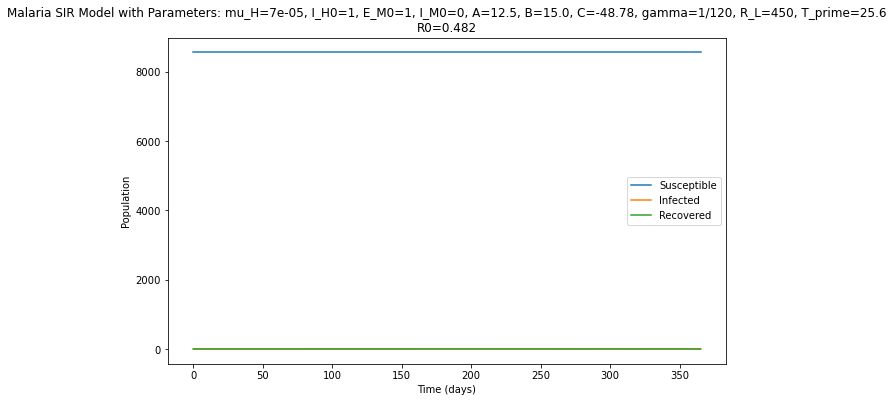

In [10]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(population_dynamics_model, [0, 365], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: mu_H={round(mu_H, 5)}, I_H0={I_H0}, E_M0={E_M0}, I_M0={I_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

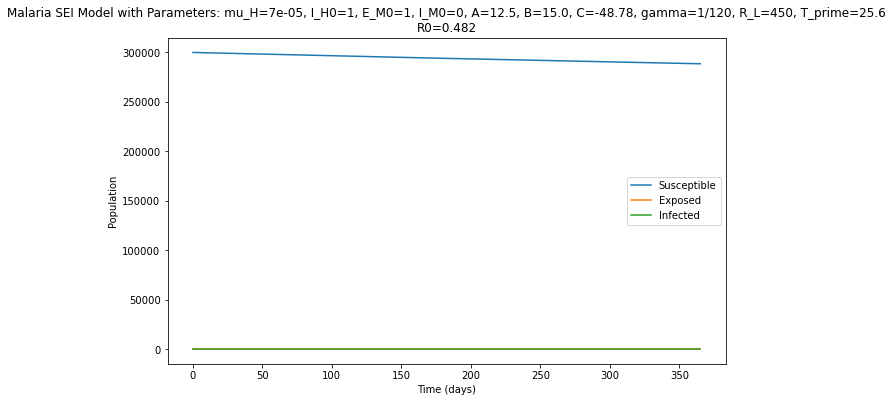

In [11]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(population_dynamics_model, [0, 365], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: mu_H={round(mu_H, 5)}, I_H0={I_H0}, E_M0={E_M0}, I_M0={I_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

#### Analyzing in 5 years:

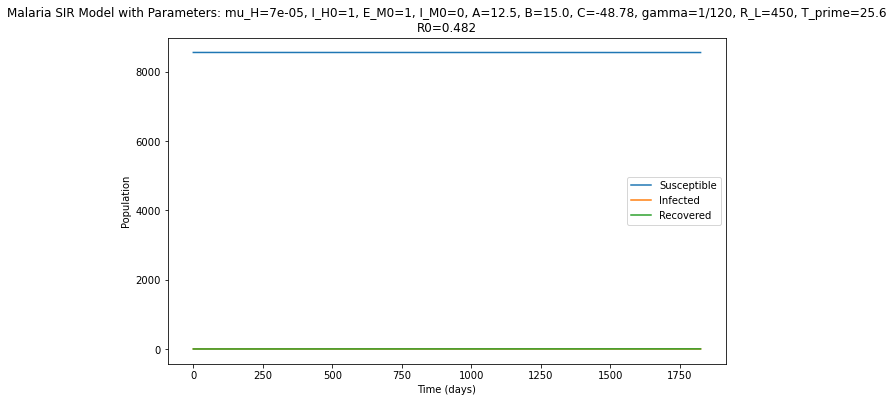

In [12]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: mu_H={round(mu_H, 5)}, I_H0={I_H0}, E_M0={E_M0}, I_M0={I_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

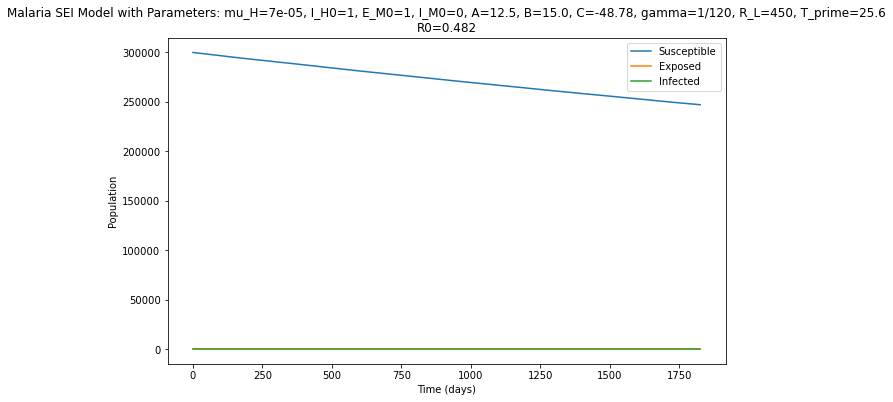

In [13]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: mu_H={round(mu_H, 5)}, I_H0={I_H0}, E_M0={E_M0}, I_M0={I_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()